# 선박 입출항데이터의 다변량 상관관계 분석

### --- 분석 배경 및 목적 ---

수출의존도가 높은 우리나라는 전염병이나 전쟁, 유가 등의 외적인 요인으로 경제성장에 쉽게 타격을 받을 수 있다. 
하지만 데이터분석을 통해 미래를 통계적으로 예측해본다면 위험관리와 불확실성 제거에 도움이 될 수 있을 것이다.

많은 데이터들 중에서 선박입출항데이터는 우리나라의 글로벌 경제 영향력과 규모를 거시적으로 가늠해 볼 수 있는 특성을 지녔다.
또한 선박의 교통밀도 분석이 가능하여 원할한 통항로를 선주들에게 제공할 수 있고 안전사고 감소에도 이바지 할 수 있다.

이에 미국금리, 유가, 환율 등 각종 경제지표를 입력 파라미터로 간주하여 주요 요인이 무엇인지 파악해보는 것을 목표로 한다.
분석된 주요요인들을 바탕으로 예측모델링을 수행하고 예측치를 구하는 것을 향후 작업의 방향을 결정할 것이다. 

# 1. 데이터셋 읽기

### (1) 필요한 모듈 설치 
##### - 주석을 풀고 한 번만 실행하면 됩니다!

In [ ]:
# !pip install seaborn 
# !pip install matplotlib 
# !pip install pandas
# !pip install openpyxl
# !pip install scipy

### (2) 선박입출항 데이터셋 읽기

In [ ]:
import pandas as pd

# 데이터출처: 포트미스
df = pd.read_excel('./ship_20231012.xlsx', skiprows=[0,1,2])

# 컬럼명 변경
df.columns = ['조회년도', '조회월', '총계_척수', '총계_톤수', 
              '입항_계_척수', '입항_계_톤수', '입항_외항_척수', '입항_외항_톤수', '입항_내항_척수', '입항_내항_톤수', 
              '출항_계_척수', '출항_계_톤수', '출항_외항_척수', '출항_외항_톤수', '출항_내항_척수', '출항_내항_톤수']

df = df.ffill() # 빈값 채우기
df = df[df['조회월']!='소계'] # data가 '소계'인 경우는 모두 제외

# 조회년도에서 '년'과 '월'없애기
df['period'] = df['조회년도'].str.replace("년",'') + df['조회월'].str.replace('월','')

# 기간, 입항, 출항 데이터만 남기기
df = df[['period', '입항_계_척수', '출항_계_척수']]

df.columns = ['period', 'arr', 'dep'] # 컬럼명 변경
df['period'] = pd.to_numeric(df['period']) # 기간을 숫자로 인식하도록 설정
df_ship = df[df["period"] > 202107] # 2021년 7월 이후 데이터만 추출

# 기간을 인덱스로 설정
df_ship.set_index(df_ship['period'], inplace=True)

print(df_ship)

### (3) 미국 기준 금리 데이터셋 읽기


In [ ]:
import numpy as np

# 데이터출처: 미연방준비제도이사회
df = pd.read_csv('./FRB_PRATES.csv', skiprows=5)
df.columns = ['period', 'RESBME', 'ESBMS', 'RESBM']

# 기간 데이터의 '-'없애기
df["period"] = df['period'].astype(str).str.replace('-', '')
df["period"] = df['period'].astype(int)  # 기간을 숫자로 인식하도록 설정

# 기간을 날짜로 인식하도록 설정
df['period'] = pd.to_datetime(df['period'], format='%Y%m%d') 

# 기간을 인덱스로 설정
df.set_index(df['period'], inplace=True)

# 일별 데이터롸 월별 데이터로 변환
df = df.resample('M').mean()

df["period"] = df.index #인덱스인 날짜 값을 '기간'열에 대입
df["period"] = df['period'].astype(str).str.replace('-', '') # 기간에서 짝대기 제거
df["period"] = df['period'].astype(str).str[:6] # 날짜의 일단위 없애기
df['period'] = pd.to_numeric(df['period']) # 기간을 숫자로 인식하도록 설정

df = df[df["period"] > 202107] # 2021년 7월 이후 데이터만 추출
df_us_ir = df[df["period"] < 202309] # 2023년 9월 미만 데이터만 추출

df_us_ir.set_index(df_us_ir['period'], inplace=True)
df_us_ir = df_us_ir[['RESBM']] # 기준금리 데이터만 추출
print(df_us_ir)

### (4) 선박용 유가 데이터셋 읽기

In [ ]:
# 데이터출처: OPINET
df = pd.read_csv('./정유사_월간판매가격_회사별.csv',encoding='EUC-KR')

df.columns = [ 'period', 'SK', 'GS', 'HD', 'S-OIL', 'SK_gas', 'E1']
df['period'] = df['period'].str.replace("년",'').str.replace('월','') # 년월 글자 제거

df['period'] = pd.to_numeric(df['period']) # 값을 숫자 타입으로 변경
df.set_index(df['period'], inplace=True) # 기간을 인덱스로 설정

df_oil = df[['S-OIL']].copy() # 유가만 추출

print(df_oil)

### (5) 원/달러 환율 데이터셋 읽기

In [ ]:
# 데이터출처: e-나라지표
df = pd.read_excel('./환율.xlsx', skiprows=[0,1], header=None).T
df.columns = ['period', 'cur_rate','diff']
df = df[2:][:] # 엑셀에서 필요한 부분만 추출
df['period'] = df['period'].str.replace("년",'').str.replace('월','') # 년월 제거
df['cur_rate'] = df['cur_rate'].str.replace(",",'') # 쉽표제거
df['period'] = pd.to_numeric(df['period']) # 값을 숫자 타입으로 변경
df['cur_rate'] = pd.to_numeric(df['cur_rate']) # 값을 숫자 타입으로 변경
df.set_index(df['period'], inplace=True) # 기간을 인덱스로 설정

df_curr= df[['cur_rate']].copy() # 환율만 추출

print(df_curr)

### (6) 데이터 합치기

In [ ]:
# 읽어온 데이터를 가로로 붙이기
df = pd.concat([df_ship, df_us_ir, df_oil, df_curr], axis=1)
print(df)

## 2. 데이터셋의 중요 특징을 시각화

### (1) 여러 요인을 산점도에 그려서 상관관계 분석

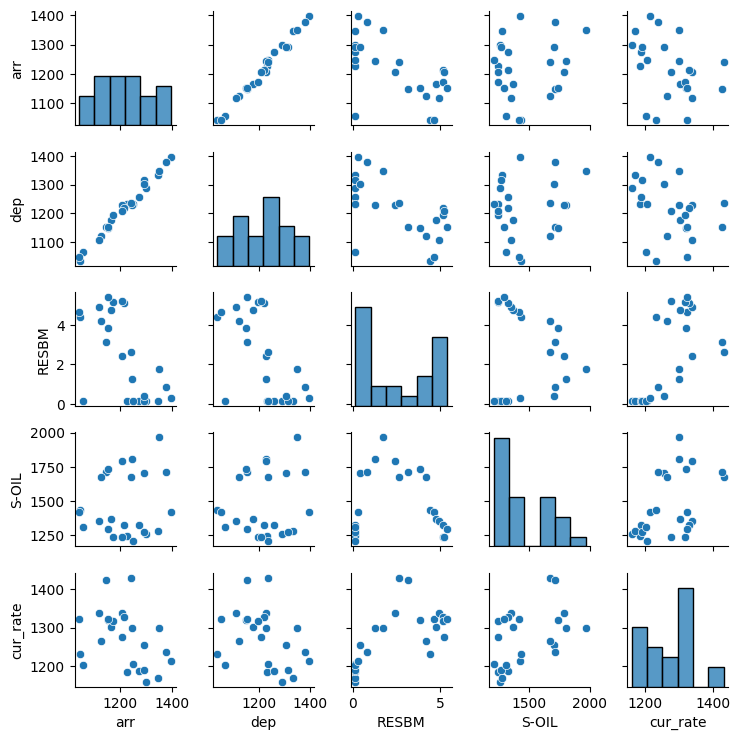

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 행렬로 각 특성간의 상관관계를 한 번에 시각화
cols = ['arr', 'dep', 'RESBM', 'S-OIL', 'cur_rate']

# 수치형 데이터를 짝을 지어줌
sns.pairplot(df[cols], height=1.5)
plt.tight_layout()
plt.show()


### (2) 상관계수를 히트맵으로 나타내기

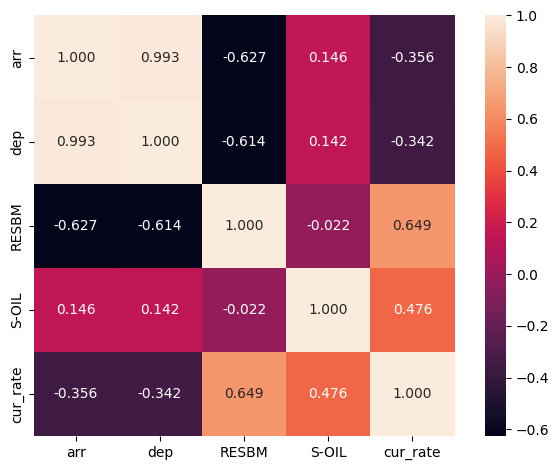

In [132]:
import numpy as np

# 상관계수 구하기
corr = np.corrcoef(df[cols].values.T)

# 상관계수 행렬을 히트맵으로 표현
hm = sns.heatmap(corr,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.3f',
                 annot_kws={'size': 10},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.show()

### (3) 유의 확률로 통계적 검증

In [151]:
import scipy.stats as stats

# 선박의 입항(척수)와 미국기준금리 상관관계 검증
X = df['arr'].values
Y = df['RESBM'].values

# 선박의 입항(척수)와 환율의 상관관계 검증
# X = df['arr'].values
# Y = df['cur_rate'].values

cov = (np.sum(X*Y) - len(X)*np.mean(X)*np.mean(Y)) / len(X)
# cov = np.cov(X, Y) #넘파이를 이용한 공분산
print('공분산', cov)

corr = cov/(np.std(X) * np.std(Y))
print('직접계산한 상관계수', corr)

r = np.corrcoef(X, Y)
print('넘파이를 이용한 상관계수', r)


# scipy모듈을 이용한 상관계수와 유의확률
# 결론: 유의확률이 0.05미만이면 두 요인간의 상관관계가 통계적으로 유의함
stats.pearsonr(X,Y)


-2519.964319999814
-0.3558972007882664
[[ 1.        -0.3558972]
 [-0.3558972  1.       ]]


PearsonRResult(statistic=-0.35589720078829273, pvalue=0.0807983148639846)